In [1]:
# Kutuphanelerin Yuklenmesi ve Konfigurasyon
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import time
import warnings

# Scikit-learn (Sadece veri isleme ve metrikler icin)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, roc_curve, auc, 
                             f1_score, precision_recall_curve, average_precision_score, 
                             roc_auc_score)
from sklearn.manifold import TSNE

# PyTorch Kutuphaneleri
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Ayarlar
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Cihaz Secimi (GPU varsa kullanir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sistem Baslatildi. Kullanilan Cihaz: {device}")


Sistem Baslatildi. Kullanilan Cihaz: cpu


Veri seti basariyla yuklendi. Ham Boyutlar: (1911073, 43)
Sutun filtresi uygulandi. Yeni Boyutlar: (1911073, 36)


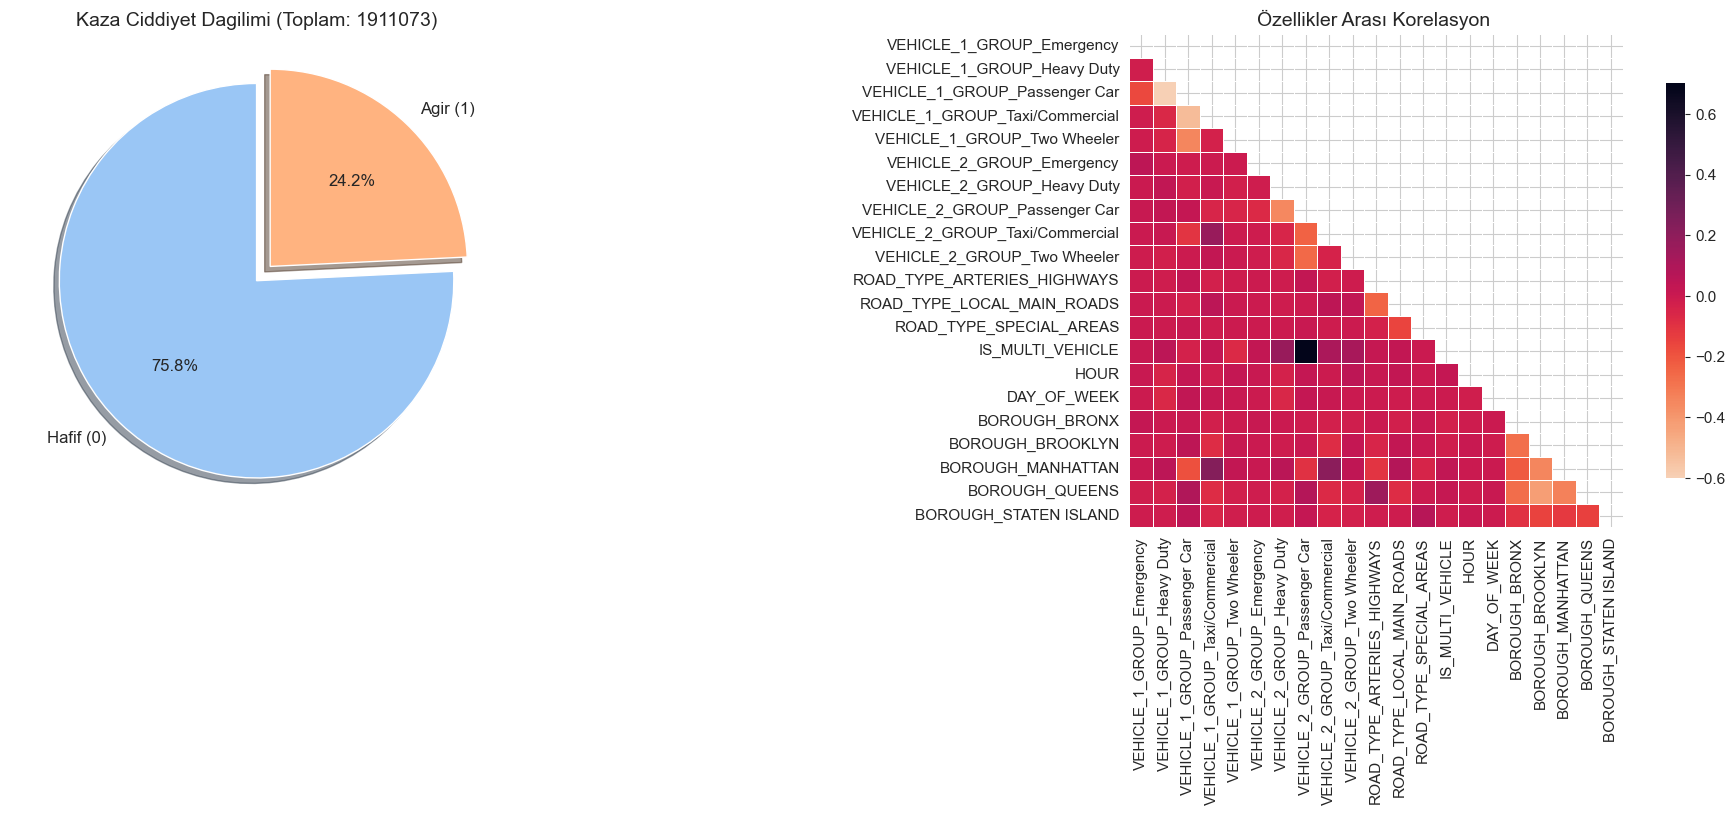

Veri görselleştirildi  ve model eğitimine hazır.


In [2]:
# --- 1. VERİ YÜKLEME VE İŞLEME ---
file_name = "NYC_Crash_Model_Final_Last.csv"

try:
    df = pd.read_csv(file_name)
    print(f"Veri seti basariyla yuklendi. Ham Boyutlar: {df.shape}")
except FileNotFoundError:
    raise FileNotFoundError("Belirtilen dosya bulunamadi.")

target_col = 'SEVERITY'

df[target_col] = df[target_col].replace(2, 1)

# Sütun Seçimi 
selected_features = [
    'VEHICLE_1_GROUP_Emergency', 'VEHICLE_1_GROUP_Heavy Duty', 
    'VEHICLE_1_GROUP_Passenger Car', 'VEHICLE_1_GROUP_Taxi/Commercial', 
    'VEHICLE_1_GROUP_Two Wheeler',
    'VEHICLE_2_GROUP_Emergency', 'VEHICLE_2_GROUP_Heavy Duty', 
    'VEHICLE_2_GROUP_Passenger Car', 'VEHICLE_2_GROUP_Taxi/Commercial', 
    'VEHICLE_2_GROUP_Two Wheeler',
    'ROAD_TYPE_ARTERIES_HIGHWAYS', 'ROAD_TYPE_LOCAL_MAIN_ROADS', 'ROAD_TYPE_SPECIAL_AREAS',
    'IS_MULTI_VEHICLE',
    'HOUR', 'DAY_OF_WEEK',
    'BOROUGH_BRONX', 'BOROUGH_BROOKLYN', 'BOROUGH_MANHATTAN', 
    'BOROUGH_QUEENS', 'BOROUGH_STATEN ISLAND',
    'FACTOR_1_GROUP_Aggressive Driving', 'FACTOR_1_GROUP_Distracted',
    'FACTOR_1_GROUP_Environmental', 'FACTOR_1_GROUP_Fatigued',
    'FACTOR_1_GROUP_Impaired', 'FACTOR_1_GROUP_Mechanical Failure',
    'FACTOR_1_GROUP_Unspecified',
    'FACTOR_2_GROUP_Aggressive Driving', 'FACTOR_2_GROUP_Distracted',
    'FACTOR_2_GROUP_Environmental', 'FACTOR_2_GROUP_Fatigued',
    'FACTOR_2_GROUP_Impaired', 'FACTOR_2_GROUP_Mechanical Failure',
    'FACTOR_2_GROUP_No Contribution'
]

# DataFrame'i filtrele
try:
    df = df[selected_features + [target_col]]
    print(f"Sutun filtresi uygulandi. Yeni Boyutlar: {df.shape}")
except KeyError as e:
    print(f"HATA: Secilen sutunlardan bazilari CSV dosyasinda bulunamadi: {e}")
    raise

# --- 2. GÖRSELLEŞTİRME  ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.set_style("white") # Arka planı temizle

# A) Pasta Grafiği 
counts = df[target_col].value_counts()
labels = [f'Hafif (0)', f'Agir (1)']
# Resimdeki renklere birebir uyan kodlar:
colors = ['#9ac6f5', '#ffb380'] 
explode = (0, 0.1)  # Agir dilimini dışarı fırlat

axes[0].pie(counts, labels=labels, autopct='%1.1f%%', 
            startangle=90, colors=colors, explode=explode, 
            shadow=True, textprops={'fontsize': 12})
axes[0].set_title(f'Kaza Ciddiyet Dagilimi (Toplam: {len(df)})', fontsize=14)

# B) Isı Haritası 
# Resimdeki gibi temiz görünmesi için 'FACTOR' sütunlarını görselleştirmeden hariç tutuyorum.
corr_cols = [col for col in selected_features if 'FACTOR' not in col]
corr_matrix = df[corr_cols].corr()

# Üst üçgeni gizlemek için maske 
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, cmap='rocket_r', 
            vmax=0.7, vmin=-0.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8},
            ax=axes[1])

axes[1].set_title('Özellikler Arası Korelasyon ', fontsize=14)

plt.tight_layout()
plt.show()

# --- 3. EĞİTİM VE TEST VERİSİNİN HAZIRLANMASI ---
X = df.drop(columns=[target_col])
y = df[target_col]

# Stratified Split
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
except ValueError:
    print("UYARI: Stratify yapilamadi. Normal split yapiliyor.")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

# Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

print("Veri görselleştirildi  ve model eğitimine hazır.")

In [3]:
X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)

X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

# 2. Sinif Agirliklarinin Hesaplanmasi (Balanced Class Weight icin)
# Formül: Negatif Sayisi / Pozitif Sayisi
num_pos = torch.sum(y_train_tensor == 1)
num_neg = torch.sum(y_train_tensor == 0)
pos_weight = num_neg / num_pos
print(f"Sinif Dengesizligi Katsayisi (pos_weight): {pos_weight.item():.4f}")
print("(Bu deger Loss fonksiyonuna verilerek modelin dengeli ogrenmesi saglanacak.)")

# 3. Dataset ve DataLoader
class CrashDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CrashDataset(X_train_tensor, y_train_tensor)
# Batch size'i 64 veya 128 secebiliriz
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print("PyTorch DataLoader hazirlandi.")


Sinif Dengesizligi Katsayisi (pos_weight): 3.1254
(Bu deger Loss fonksiyonuna verilerek modelin dengeli ogrenmesi saglanacak.)
PyTorch DataLoader hazirlandi.


In [4]:
# Model Mimarileri (CNN ve RNN)

# Model 1: 1D-CNN (Convolutional Neural Network)
class CrashCNN(nn.Module):
    def __init__(self, input_dim):
        super(CrashCNN, self).__init__()
        # 1. Konvolusyon Blogu
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(0.3)
        
        # 2. Tam Baglantili (Fully Connected) Blok
        # Input dim // 2 cunku MaxPool boyutu yariya indirdi
        self.fc1 = nn.Linear(64 * (input_dim // 2), 64) 
        self.fc2 = nn.Linear(64, 1)
        
    def forward(self, x):
        # Giris: (Batch, Features) -> (Batch, 1, Features)
        x = x.unsqueeze(1) 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x # Sigmoid Loss fonksiyonunun icinde yapilacak (BCEWithLogitsLoss)
        
# Model 2: RNN (Recurrent Neural Network - GRU Varyasyonu)
class CrashRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(CrashRNN, self).__init__()
        # GRU Katmani
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, 
                          num_layers=num_layers, batch_first=True, dropout=0.3)
        
        # Cikis Katmani
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        # Giris: (Batch, Features) -> (Batch, 1, Features) seklinde sequence gibi veriyoruz
        x = x.unsqueeze(1) 
        
        # GRU Ciktisi
        # out: (batch, seq_len, hidden_dim)
        out, _ = self.gru(x)
        
        # Son zaman adimini aliyoruz
        out = out[:, -1, :] 
        out = self.fc(out)
        return out

print("CNN ve RNN model mimarileri tanimlandi.")

CNN ve RNN model mimarileri tanimlandi.


In [5]:
# Gelişmiş Eğitim Döngüsü Fonksiyonu (Metrik Takibi Dahil)
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score

def train_pytorch_model(model, loader, X_val, y_val, pos_weight, epochs=20, lr=0.001, model_name="Model"):
    model.train()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    # Metrikleri kaydetmek için sözlük
    history = {'loss': [], 'accuracy': [], 'recall': [], 'f1': [], 'auc': []}
    
    print(f"--- {model_name} Eğitimi Başlıyor ({epochs} Epoch) ---")
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Her Epoch sonunda Validation Metriklerini Hesapla
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            # Sigmoid uygulayıp olasılıkları alıyoruz
            val_probs = torch.sigmoid(val_outputs).cpu().numpy().flatten()
            val_preds = (val_probs > 0.5).astype(int)
            y_true = y_val.cpu().numpy().flatten()
            
            # Sklearn Metrikleri
            acc = accuracy_score(y_true, val_preds)
            rec = recall_score(y_true, val_preds)
            f1 = f1_score(y_true, val_preds)
            auc_val = roc_auc_score(y_true, val_probs)
            avg_loss = epoch_loss / len(loader)
            
            # Geçmişe kaydet
            history['loss'].append(avg_loss)
            history['accuracy'].append(acc)
            history['recall'].append(rec)
            history['f1'].append(f1)
            history['auc'].append(auc_val)
            
            # Her epoch'u ekrana yazdır 
            print(f"Epoch {epoch+1:02d}/{epochs} | Loss: {avg_loss:.4f} | Acc: {acc:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | AUC: {auc_val:.4f}")
            
    return history

print("Gelişmiş eğitim fonksiyonu hazırlandı.")

Gelişmiş eğitim fonksiyonu hazırlandı.



[1D-CNN] Model Başlatılıyor...
--- 1D-CNN Eğitimi Başlıyor (20 Epoch) ---
Epoch 01/20 | Loss: 0.9365 | Acc: 0.6936 | Rec: 0.5400 | F1: 0.4608 | AUC: 0.7027
Epoch 02/20 | Loss: 0.9324 | Acc: 0.7105 | Rec: 0.5081 | F1: 0.4597 | AUC: 0.7032
Epoch 03/20 | Loss: 0.9313 | Acc: 0.7214 | Rec: 0.4837 | F1: 0.4571 | AUC: 0.7030
Epoch 04/20 | Loss: 0.9309 | Acc: 0.7063 | Rec: 0.5163 | F1: 0.4601 | AUC: 0.7038
Epoch 05/20 | Loss: 0.9304 | Acc: 0.6953 | Rec: 0.5402 | F1: 0.4622 | AUC: 0.7048
Epoch 06/20 | Loss: 0.9302 | Acc: 0.7054 | Rec: 0.5195 | F1: 0.4609 | AUC: 0.7050
Epoch 07/20 | Loss: 0.9300 | Acc: 0.7321 | Rec: 0.4658 | F1: 0.4574 | AUC: 0.7048
Epoch 08/20 | Loss: 0.9298 | Acc: 0.7183 | Rec: 0.4968 | F1: 0.4609 | AUC: 0.7049
Epoch 09/20 | Loss: 0.9297 | Acc: 0.7066 | Rec: 0.5195 | F1: 0.4619 | AUC: 0.7048
Epoch 10/20 | Loss: 0.9297 | Acc: 0.7207 | Rec: 0.4919 | F1: 0.4606 | AUC: 0.7053
Epoch 11/20 | Loss: 0.9297 | Acc: 0.6965 | Rec: 0.5351 | F1: 0.4608 | AUC: 0.7043
Epoch 12/20 | Loss: 0.9

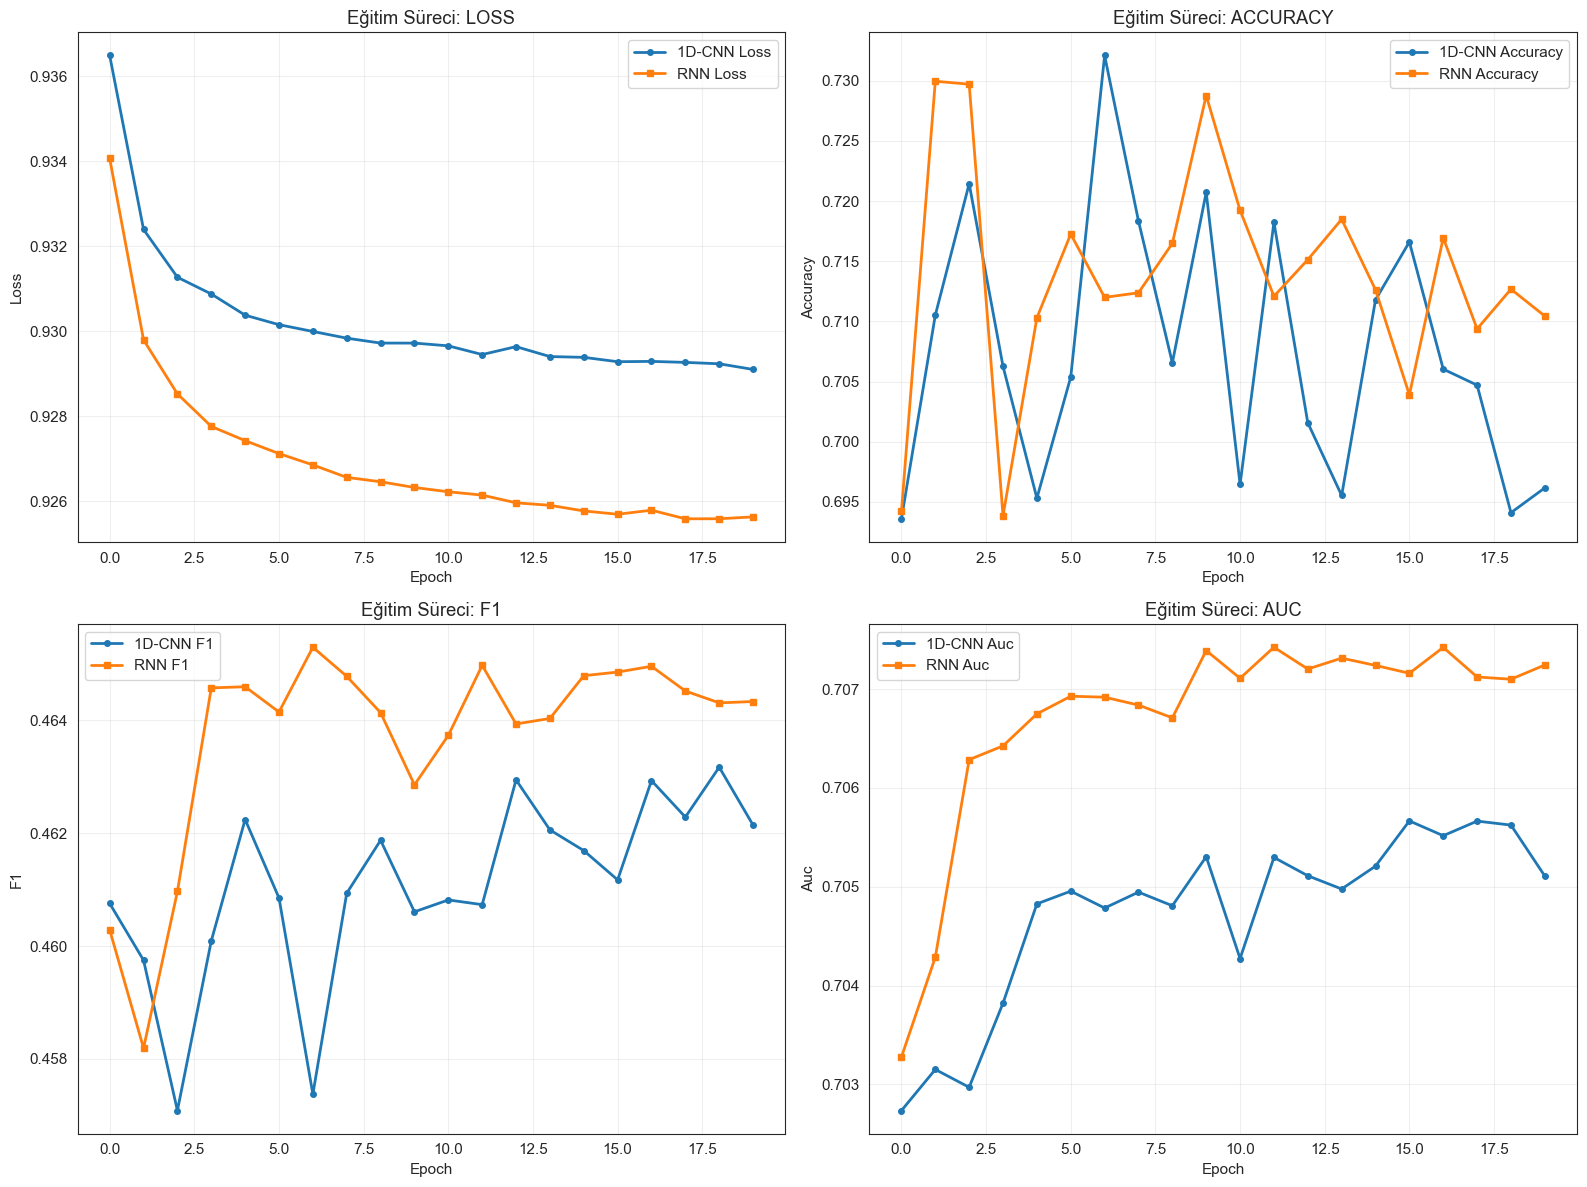

In [6]:
# Modellerin Eğitilmesi ve Süreç Görselleştirme

input_dim = X_train.shape[1]

# 1. 1D-CNN Modeli Eğitimi 
print("\n[1D-CNN] Model Başlatılıyor...")
cnn_model = CrashCNN(input_dim).to(device)
cnn_history = train_pytorch_model(cnn_model, train_loader, X_test_tensor, y_test_tensor, 
                                  pos_weight=pos_weight, epochs=20, model_name="1D-CNN")

# 2. RNN (GRU) Modeli Eğitimi
print("\n[RNN/GRU] Model Başlatılıyor...")
rnn_model = CrashRNN(input_dim).to(device)
rnn_history = train_pytorch_model(rnn_model, train_loader, X_test_tensor, y_test_tensor, 
                                  pos_weight=pos_weight, epochs=20, model_name="RNN")

# EĞİTİM SÜRECİ GRAFİKLERİ 
metrics = ['loss', 'accuracy', 'f1', 'auc']
plt.figure(figsize=(16, 12))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    plt.plot(cnn_history[metric], label=f'1D-CNN {metric.capitalize()}', color='#1f77b4', lw=2, marker='o', markersize=4)
    plt.plot(rnn_history[metric], label=f'RNN {metric.capitalize()}', color='#ff7f0e', lw=2, marker='s', markersize=4)
    plt.title(f'Eğitim Süreci: {metric.upper()}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


--- MODELLER ARASI PERFORMANS TABLOSU ---


,Model,Accuracy,Recall,F1-Score,AUC,Final Loss
0,1D-CNN,0.6962,0.5385,0.4621,0.7051,0.9291
1,RNN (GRU),0.7104,0.5177,0.4643,0.7072,0.9256


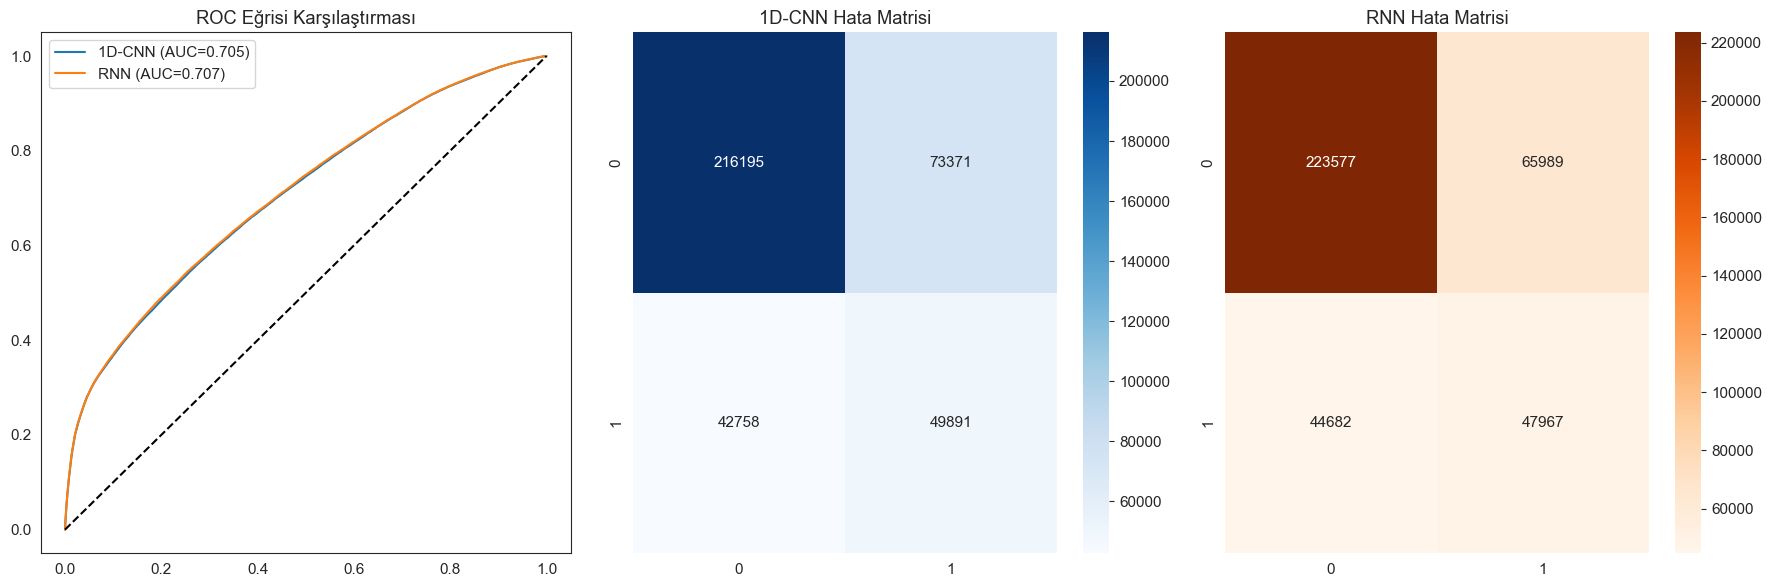

In [7]:
# Hücre 7: Karşılaştırma Tablosu, Hata Matrisi ve ROC Eğrileri

# --- A) PERFORMANS TABLOSU ---
comparison_data = []
for name, hist in [("1D-CNN", cnn_history), ("RNN (GRU)", rnn_history)]:
    comparison_data.append({
        'Model': name,
        'Accuracy': f"{hist['accuracy'][-1]:.4f}",
        'Recall': f"{hist['recall'][-1]:.4f}",
        'F1-Score': f"{hist['f1'][-1]:.4f}",
        'AUC': f"{hist['auc'][-1]:.4f}",
        'Final Loss': f"{hist['loss'][-1]:.4f}"
    })

print("\n--- MODELLER ARASI PERFORMANS TABLOSU ---")
display(pd.DataFrame(comparison_data))

# --- B) SENİN ESKİ EVALUATION KODLARIN  ---
def evaluate_model(model, X_tensor, y_true):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        preds = (probs > 0.5).astype(int)
    return probs, preds

cnn_probs, cnn_preds = evaluate_model(cnn_model, X_test_tensor, y_test)
rnn_probs, rnn_preds = evaluate_model(rnn_model, X_test_tensor, y_test)

plt.figure(figsize=(18, 6))

# ROC Eğrisi
plt.subplot(1, 3, 1)
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, cnn_probs)
fpr_rnn, tpr_rnn, _ = roc_curve(y_test, rnn_probs)
plt.plot(fpr_cnn, tpr_cnn, label=f'1D-CNN (AUC={roc_auc_score(y_test, cnn_probs):.3f})')
plt.plot(fpr_rnn, tpr_rnn, label=f'RNN (AUC={roc_auc_score(y_test, rnn_probs):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Eğrisi Karşılaştırması')
plt.legend()

# Hata Matrisi (CNN)
plt.subplot(1, 3, 2)
sns.heatmap(confusion_matrix(y_test, cnn_preds), annot=True, fmt='d', cmap='Blues')
plt.title('1D-CNN Hata Matrisi')

# Hata Matrisi (RNN)
plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix(y_test, rnn_preds), annot=True, fmt='d', cmap='Oranges')
plt.title('RNN Hata Matrisi')

plt.tight_layout()
plt.show()

[SHAP] KernelExplainer başlatıldı. Bu yöntem biraz zaman alabilir, lütfen bekleyin...


  0%|          | 0/20 [00:00<?, ?it/s]

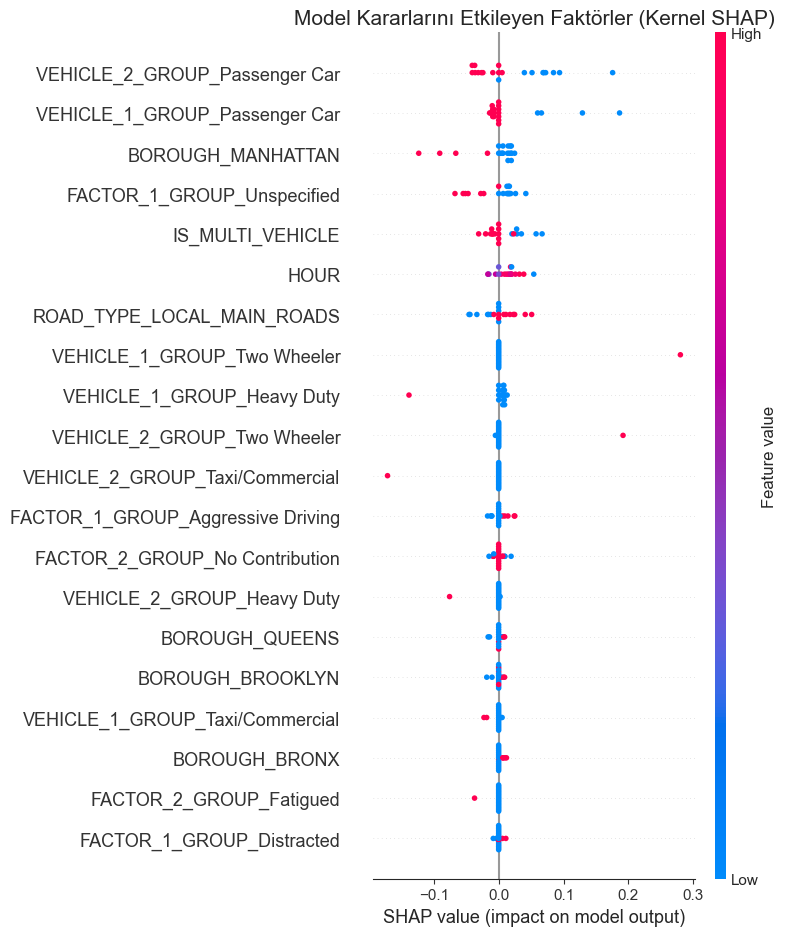

In [8]:
# SHAP Analizi (Mimariden Bağımsız - Garantili Versiyon)
import shap

# 1. Modelin sadece numpy alıp olasılık döndüren bir fonksiyonunu tanımlayalım
# Çünkü KernelExplainer modelin içine bakmaz, girdi-çıktıya bakar.
def model_predict_proba(x_numpy):
    model_to_use = cnn_model 
    model_to_use.eval()
    with torch.no_grad():
        # Numpy -> Tensor
        x_tensor = torch.tensor(x_numpy, dtype=torch.float32).to(device)
        # Model tahmini
        outputs = model_to_use(x_tensor)
        # Olasılığa çevir (Sigmoid)
        probs = torch.sigmoid(outputs).cpu().numpy()
    return probs

# 2. Verileri hazırla
# KernelExplainer yavaştır, bu yüzden küçük ama öz bir veri kümesi kullanıyoruz
background_data = X_train_scaled[:50] 
test_data = X_test_scaled[:20]       

# 3. Explainer'ı Başlat 
print("[SHAP] KernelExplainer başlatıldı. Bu yöntem biraz zaman alabilir, lütfen bekleyin...")
explainer = shap.KernelExplainer(model_predict_proba, background_data)

# 4. SHAP Değerlerini Hesapla
shap_values = explainer.shap_values(test_data)

# 5. Görselleştirme
# KernelExplainer çıktısı bazen (N, Features, 1) olabilir, düzeltiyoruz
if isinstance(shap_values, list):
    val = shap_values[0]
else:
    val = shap_values

# Boyutları temizle 
shap_values_final = np.squeeze(val)
input_data_final = np.squeeze(test_data)

plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_final, 
    input_data_final, 
    feature_names=selected_features, 
    show=False
)
plt.title("Model Kararlarını Etkileyen Faktörler (Kernel SHAP)", fontsize=15)
plt.tight_layout()
plt.show()